# Building the ML dataframe

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

In [3]:
# Set max number of columns to display; default 20
pd.options.display.max_columns = 80

In [4]:
# Directory where data files will be downloaded
cwd_path = Path.cwd()
data_path = cwd_path.parent.joinpath('data')
data_push_path = cwd_path.parent.joinpath('data_to_push')

#### Load in latest wind turbine data
- Note: Only 9 turbines decommissioned before 2019!

In [375]:
# Read in latest turbine data
# Now only 30,642 after removing 3 turbines outside bounding box
df_turbines = pd.read_pickle(data_push_path / 'df_turbines_knn_blades_haversine_elevation_utc.pkl')
df_turbines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30642 entries, 0 to 30641
Data columns (total 30 columns):
 #   Column                                            Non-Null Count  Dtype              
---  ------                                            --------------  -----              
 0   EinheitMastrNummer                                30642 non-null  object             
 1   DatumLetzteAktualisierung                         30642 non-null  datetime64[ns, UTC]
 2   Bundesland                                        30642 non-null  object             
 3   Postleitzahl                                      30642 non-null  int64              
 4   Ort                                               30642 non-null  object             
 5   Laengengrad                                       30642 non-null  float64            
 6   Breitengrad                                       30642 non-null  float64            
 7   Registrierungsdatum                               30642 non-null  d

In [376]:
# List of datetime column names for convenient indexing later
turbine_date_columns = [
    'DatumLetzteAktualisierung',
    'Registrierungsdatum',
    'Inbetriebnahmedatum',
    'DatumEndgueltigeStilllegung',
    'DatumBeginnVoruebergehendeStilllegung',
    'DatumWiederaufnahmeBetrieb'
]

In [371]:
# # Cast all tz naive datetime64 columns to UTC tz aware
# df_turbines[turbine_date_columns] = df_turbines[turbine_date_columns].apply(lambda series: series.dt.tz_localize('UTC'), axis=0)

# # save to pickle
# df_turbines.to_pickle(data_push_path / 'df_turbines_knn_blades_haversine_elevation_utc.pkl')

-----

# Load in all SMARD data

#### Load in SMARD energy generated data (actual measured generation)
- My response variable `y` (aka target/label) 

In [743]:
# Get all SMARD CSV files, load into dataframes, and concat them

def load_SMARD_generated_data():
    """
    Look for CSV files in the SMARD directory
    """
    list_of_dataframes = []
    for filepath in data_path.joinpath('SMARD').iterdir():
        if filepath.name.startswith('Realisierte_Erzeugung'):
            list_of_dataframes.append(pd.read_csv(filepath, sep=';'))
            
    # Check that num of rows is what I expect after concatenating dfs
    num_of_rows = 0
    for df in list_of_dataframes:
        num_of_rows += len(df)
    
    # concat dataframes
    df = pd.concat(list_of_dataframes)
    print(f'Number of rows match up: {num_of_rows == len(df)}')
    
    # Select columns to keep
    # Note: I'm using the interval start time to create the timestamps
    # ERA5 surface parameters are instantaneous so can't perfectly align anyway
    df = df[[
        'Datum',
        'Anfang',
        # 'Ende',
        'Wind Onshore [MWh] Berechnete Auflösungen'
    ]]
    
    # rename columns
    df.rename(columns={
        'Datum': 'date',
        'Anfang': 'interval_start_time', 
        # 'Ende': 'interval_end_time',
        'Wind Onshore [MWh] Berechnete Auflösungen': 'onshore_generated_mwh'
    }, inplace=True)
    
    # Handle dates and times to create unified datetime64 timestamps
    df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
    df['start_time_delta'] = pd.to_timedelta(df['interval_start_time'] + ':00')
    df['datetime_cet'] = df['date'] + df['start_time_delta']
    # Add CET timezone info and infer change from CET->CEST->CET, etc
    df['datetime_cet'] = df['datetime_cet'].dt.tz_localize(tz='CET', ambiguous='infer')
    
    # Drop un-needed columns
    df = df.drop(columns=['date', 'start_time_delta', 'interval_start_time'])
    # Re-arrange columns
    df = df[['datetime_cet', 'onshore_generated_mwh']]
    
    # Convert European thousands and decimal seperators in values to (US/UK) decimal full stop format
    translation_table = str.maketrans({'.': None, ',': '.'})
    df['onshore_generated_mwh'] = df['onshore_generated_mwh'].str.translate(translation_table).astype(float)
    
    # Sort rows by datetime_cet
    df.sort_values('datetime_cet', inplace=True)
    # Reset index
    df.reset_index(drop=True, inplace=True)
    
    return df.copy()

In [744]:
# Load SMARD data
df_smard_generated = load_SMARD_generated_data()
df_smard_generated.info()

Number of rows match up: True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49655 entries, 0 to 49654
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   datetime_cet           49655 non-null  datetime64[ns, CET]
 1   onshore_generated_mwh  49655 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 776.0 KB


In [745]:
# df_smard[df_smard['datetime'] < pd.Timestamp('2022-10-30')]

In [768]:
df_smard_generated.isna().sum()

datetime_cet             0
onshore_generated_mwh    0
dtype: int64

In [746]:
df_smard_generated.head(3)

,datetime_cet,onshore_generated_mwh
0,2018-01-01 00:00:00+01:00,28503.50
1,2018-01-01 01:00:00+01:00,29638.00
2,2018-01-01 02:00:00+01:00,30173.75


-----

#### Load in SMARD day-ahead prices
- Wholesale prices: https://www.smard.de/page/en/wiki-article/5884/5976
- This is the day-ahead price!
    - "Weighted wholesale electricity price (day-ahead price on the exchange) for each hour [€/MWh] determined on the day-ahead auction that took place ones on the previous day - data is delivered no later than 2 hours after trading closes. Source: ENTSO-E"
- Data only goes back to 2018-10-01 (October 1, 2018)

In [716]:
# Get all SMARD CSV files, load into dataframes, and concat them

def load_SMARD_market_price_data():
    """
    Look for CSV files in the SMARD directory
    """
    list_of_dataframes = []
    for filepath in data_path.joinpath('SMARD').iterdir():
        if filepath.name.startswith('Gro_handelspreise'):
            list_of_dataframes.append(pd.read_csv(filepath, sep=';', na_values='-'))
            
    # Check that num of rows is what I expect after concatenating dfs
    num_of_rows = 0
    for df in list_of_dataframes:
        num_of_rows += len(df)
    
    # concat dataframes
    df = pd.concat(list_of_dataframes)
    print(f'Number of rows match up: {num_of_rows == len(df)}')
    
    # Select columns to keep
    # Note: I'm using the interval start time to create the timestamps
    # ERA5 surface parameters are instantaneous so can't perfectly align anyway
    df = df[[
        'Datum',
        'Anfang',
        # 'Ende',
        'Deutschland/Luxemburg [€/MWh] Originalauflösungen'
    ]]
    
    # rename columns
    df.rename(columns={
        'Datum': 'date',
        'Anfang': 'interval_start_time', 
        # 'Ende': 'interval_end_time',
        'Deutschland/Luxemburg [€/MWh] Originalauflösungen': 'day_ahead_price_eur_mwh'
    }, inplace=True)
    
    # Handle dates and times to create unified datetime64 timestamps
    df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
    df['start_time_delta'] = pd.to_timedelta(df['interval_start_time'] + ':00')
    df['datetime_cet'] = df['date'] + df['start_time_delta']
    # Add CET timezone info and infer change from CET->CEST->CET, etc
    df['datetime_cet'] = df['datetime_cet'].dt.tz_localize(tz='CET', ambiguous='infer')
    
    # Drop un-needed columns
    df = df.drop(columns=['date', 'start_time_delta', 'interval_start_time'])
    # Re-arrange columns
    df = df[['datetime_cet', 'day_ahead_price_eur_mwh']]
    
    # Convert European thousands and decimal seperators in values to (US/UK) decimal full stop format
    translation_table = str.maketrans({'.': None, ',': '.'})
    df['day_ahead_price_eur_mwh'] = df['day_ahead_price_eur_mwh'].str.translate(translation_table).astype(float)
    
    # Sort rows by datetime_cet
    df.sort_values('datetime_cet', inplace=True)
    # Reset index
    df.reset_index(drop=True, inplace=True)
    
    return df.copy()

In [717]:
df_smard_market_price = load_SMARD_market_price_data()

Number of rows match up: True


In [718]:
# df_smard_market_price = pd.read_csv(data_path.joinpath('SMARD') / 'Gro_handelspreise_202201010000_202212312359_Stunde.csv', sep=';')

In [769]:
df_smard_market_price.isna().sum()

datetime_cet                  0
day_ahead_price_eur_mwh    6551
dtype: int64

In [719]:
df_smard_market_price.iloc[6550:].head(20)

,datetime_cet,day_ahead_price_eur_mwh
6550,2018-09-30 23:00:00+02:00,NaN
6551,2018-10-01 00:00:00+02:00,59.53
6552,2018-10-01 01:00:00+02:00,56.10
6553,2018-10-01 02:00:00+02:00,51.41
6554,2018-10-01 03:00:00+02:00,47.38
6555,2018-10-01 04:00:00+02:00,47.59
6556,2018-10-01 05:00:00+02:00,51.61
6557,2018-10-01 06:00:00+02:00,69.13
6558,2018-10-01 07:00:00+02:00,77.32
6559,2018-10-01 08:00:00+02:00,84.97


In [721]:
df_smard_market_price.isna().sum()

datetime_cet                  0
day_ahead_price_eur_mwh    6551
dtype: int64

In [720]:
df_smard_market_price['day_ahead_price_eur_mwh'].describe()

count    43848.000000
mean        98.728242
std        106.185053
min       -500.000000
25%         35.500000
50%         56.065000
75%        121.902500
max        871.000000
Name: day_ahead_price_eur_mwh, dtype: float64

-----

#### Load in SMARD installed capacity data

In [752]:
def load_SMARD_installed_capacity_data():
    """
    Look for CSV files in the SMARD directory
    """
    list_of_dataframes = []
    for filepath in data_path.joinpath('SMARD').iterdir():
        if filepath.name.startswith('Installierte_Erzeugungsleistung'):
            list_of_dataframes.append(pd.read_csv(filepath, sep=';'))
            
    # Check that num of rows is what I expect after concatenating dfs
    num_of_rows = 0
    for df in list_of_dataframes:
        num_of_rows += len(df)
    
    # concat dataframes
    df = pd.concat(list_of_dataframes)
    print(f'Number of rows match up: {num_of_rows == len(df)}')
    
    # Select columns to keep
    # Note: I'm using the interval start time to create the timestamps
    # ERA5 surface parameters are instantaneous so can't perfectly align anyway
    df = df[[
        'Datum',
        'Anfang',
        # 'Ende',
        'Wind Onshore [MW] Berechnete Auflösungen'
    ]]
    
    # rename columns
    df.rename(columns={
        'Datum': 'date',
        'Anfang': 'interval_start_time', 
        # 'Ende': 'interval_end_time',
        'Wind Onshore [MW] Berechnete Auflösungen': 'total_nominal_capacity_smard_mw'
    }, inplace=True)
    
    # Handle dates and times to create unified datetime64 timestamps
    df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
    df['start_time_delta'] = pd.to_timedelta(df['interval_start_time'] + ':00')
    df['datetime_cet'] = df['date'] + df['start_time_delta']
    # Add CET timezone info and infer change from CET->CEST->CET, etc
    df['datetime_cet'] = df['datetime_cet'].dt.tz_localize(tz='CET', ambiguous='infer')
    
    # Drop un-needed columns
    df = df.drop(columns=['date', 'start_time_delta', 'interval_start_time'])
    # Re-arrange columns
    df = df[['datetime_cet', 'total_nominal_capacity_smard_mw']]
        
    # Sort rows by datetime_cet
    df.sort_values('datetime_cet', inplace=True)
    # Reset index
    df.reset_index(drop=True, inplace=True)
    
    return df.copy()

In [753]:
df_smard_installed_capacity = load_SMARD_installed_capacity_data()

Number of rows match up: True


In [754]:
df_smard_installed_capacity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41639 entries, 0 to 41638
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   datetime_cet                     41639 non-null  datetime64[ns, CET]
 1   total_nominal_capacity_smard_mw  41639 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 650.7 KB


In [770]:
df_smard_installed_capacity.isna().sum()

datetime_cet                       0
total_nominal_capacity_smard_mw    0
dtype: int64

In [755]:
df_smard_installed_capacity.describe()

,total_nominal_capacity_smard_mw
count,41639.000000
mean,53.706053
std,1.851039
min,51.633000
25%,52.792000
50%,53.184000
75%,54.499000
max,57.590000


------

#### Load in SMARD day-ahead generation forecast
- Wind Onshore [MWh] Berechnete Auflösungen for Germany

In [790]:
def load_SMARD_forecasted_generation_data():
    """
    Look for CSV files in the SMARD directory
    """
    list_of_dataframes = []
    for filepath in data_path.joinpath('SMARD').iterdir():
        if filepath.name.startswith('Prognostizierte_Erzeugung_Day-Ahead'):
            list_of_dataframes.append(pd.read_csv(filepath, sep=';'))
            
    # Check that num of rows is what I expect after concatenating dfs
    num_of_rows = 0
    for df in list_of_dataframes:
        num_of_rows += len(df)
    
    # concat dataframes
    df = pd.concat(list_of_dataframes)
    print(f'Number of rows match up: {num_of_rows == len(df)}')
    
    # Select columns to keep
    # Note: I'm using the interval start time to create the timestamps
    # ERA5 surface parameters are instantaneous so can't perfectly align anyway
    df = df[[
        'Datum',
        'Anfang',
        # 'Ende',
        'Wind Onshore [MWh] Berechnete Auflösungen'
    ]]
    
    # rename columns
    df.rename(columns={
        'Datum': 'date',
        'Anfang': 'interval_start_time', 
        # 'Ende': 'interval_end_time',
        'Wind Onshore [MWh] Berechnete Auflösungen': 'forecasted_generation_smard_mwh'
    }, inplace=True)
    
    # Handle dates and times to create unified datetime64 timestamps
    df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
    df['start_time_delta'] = pd.to_timedelta(df['interval_start_time'] + ':00')
    df['datetime_cet'] = df['date'] + df['start_time_delta']
    # Add CET timezone info and infer change from CET->CEST->CET, etc
    df['datetime_cet'] = df['datetime_cet'].dt.tz_localize(tz='CET', ambiguous='infer')
    
    # Drop un-needed columns
    df = df.drop(columns=['date', 'start_time_delta', 'interval_start_time'])
    # Re-arrange columns
    df = df[['datetime_cet', 'forecasted_generation_smard_mwh']]
        
    # Sort rows by datetime_cet
    df.sort_values('datetime_cet', inplace=True)
    # Reset index
    df.reset_index(drop=True, inplace=True)
    
    return df.copy()

In [791]:
df_smard_forecasted_generation = load_SMARD_forecasted_generation_data()

Number of rows match up: True


In [792]:
df_smard_forecasted_generation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41639 entries, 0 to 41638
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   datetime_cet                     24095 non-null  datetime64[ns, CET]
 1   forecasted_generation_smard_mwh  24095 non-null  object             
dtypes: datetime64[ns, CET](1), object(1)
memory usage: 650.7+ KB


In [793]:
df_smard_forecasted_generation.isna().sum()

datetime_cet                       17544
forecasted_generation_smard_mwh    17544
dtype: int64

In [794]:
df_smard_forecasted_generation[df_smard_forecasted_generation.isna()]

,datetime_cet,forecasted_generation_smard_mwh
0,NaT,NaN
1,NaT,NaN
2,NaT,NaN
3,NaT,NaN
4,NaT,NaN
...,...,...
41634,NaT,NaN
41635,NaT,NaN
41636,NaT,NaN
41637,NaT,NaN


In [795]:
41639-17544

24095

In [796]:
df_smard_forecasted_generation.iloc[17085:].head(20)

,datetime_cet,forecasted_generation_smard_mwh
17085,2021-12-13 21:00:00+01:00,"8.404,5"
17086,2021-12-13 22:00:00+01:00,"8.522,75"
17087,2021-12-13 23:00:00+01:00,"8.748,25"
17088,2021-12-14 00:00:00+01:00,"9.747,75"
17089,2021-12-14 01:00:00+01:00,"10.155,75"
17090,2021-12-14 02:00:00+01:00,"10.327,75"
17091,2021-12-14 03:00:00+01:00,"10.559,25"
17092,2021-12-14 04:00:00+01:00,"10.870,25"
17093,2021-12-14 05:00:00+01:00,"11.172,25"
17094,2021-12-14 06:00:00+01:00,"11.460,25"


In [797]:
df_smard_forecasted_generation['datetime_cet'].min()

Timestamp('2018-01-01 00:00:00+0100', tz='CET')

In [798]:
df_smard_forecasted_generation['datetime_cet'].max()

Timestamp('2023-08-31 23:00:00+0200', tz='CET')

-----

-----

# Begin building ML dataframe `df_main`
- Start with one full year: 2022
    - Then bring in another year like 2021 and run through the same transformations and then concat along datetimeindex?
- Good resource on time-related feature engineering: https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html

In [799]:
# Year 2022
# Make time zone aware UTC?
datetime_index_utc = pd.date_range(start='2018-01-01', end='2023-08-31 23:59:59', freq='H', name='datetime_utc', tz='UTC')

# Make index to dataframe and reset
df_main = datetime_index_utc.to_frame().reset_index(drop=True)

# Extract properties and derive new columns
df_main['hour'] = df_main['datetime_utc'].dt.hour
# 0-6 (Monday-Sunday)
df_main['day_of_week'] = df_main['datetime_utc'].dt.dayofweek
df_main['day_of_month'] = df_main['datetime_utc'].dt.day
df_main['month_number'] = df_main['datetime_utc'].dt.month

# Function to get meteorological season based on month number (1-12)
# Should I just go ahead and encode the discrete numerical value?
def get_meteorological_season(month):
    if 3 <= month <= 5:
        return 'spring'
    elif 6 <= month <= 8:
        return 'summer'
    elif 9 <= month <= 11:
        return 'autumn'
    else:
        return 'winter'
    
df_main['meteorological_season'] = df_main['month_number'].apply(get_meteorological_season)

df_main

,datetime_utc,hour,day_of_week,day_of_month,month_number,meteorological_season
0,2018-01-01 00:00:00+00:00,0,0,1,1,winter
1,2018-01-01 01:00:00+00:00,1,0,1,1,winter
2,2018-01-01 02:00:00+00:00,2,0,1,1,winter
3,2018-01-01 03:00:00+00:00,3,0,1,1,winter
4,2018-01-01 04:00:00+00:00,4,0,1,1,winter
...,...,...,...,...,...,...
49651,2023-08-31 19:00:00+00:00,19,3,31,8,summer
49652,2023-08-31 20:00:00+00:00,20,3,31,8,summer
49653,2023-08-31 21:00:00+00:00,21,3,31,8,summer
49654,2023-08-31 22:00:00+00:00,22,3,31,8,summer


----

## Derive new columns `turbines_in_operation` and `total_nominal_capacity_operational_turbines_mw`

#### Function to check if turbine operational at a given UTC hour timestamp

In [800]:
def is_operational(timestamp_utc, df_turbines):
    """
    Inputs: hourly tz aware utc timestamps, turbine dataframe
    Get a bool series of turbines that are operational at the time of the [hourly] timestamp
    """
    # Turbines that went into operation before the timestamp; returns bool series for bool indexing
    started_operations = df_turbines['Inbetriebnahmedatum'] <= timestamp_utc

    # Turbines already decommissioned before the timestamp; returns bool series for bool indexing
    already_decommissioned = df_turbines['DatumEndgueltigeStilllegung'] <= timestamp_utc

    # Turbines that went into maintenance before timestamp and haven't come back into operation before the timestamp
    # Note: Some turbines go straight from temporary maintenance to decommissioned without ever going back into operation
    still_in_maintenance_or_decommissioned = (df_turbines['DatumBeginnVoruebergehendeStilllegung'] <= timestamp_utc) & \
    ((df_turbines['DatumWiederaufnahmeBetrieb'] > timestamp_utc) | df_turbines['DatumWiederaufnahmeBetrieb'].isna())

    # Number of turbines operational at the timestamp
    # Note the tildas to inverse these bool series
    # This is a bool series with df_turbines index
    turbines_in_operation_bool_series = (started_operations & ~already_decommissioned & ~still_in_maintenance_or_decommissioned)

    return turbines_in_operation_bool_series

##### Derive column for total turbines in operation for every hourly timestamp

In [801]:
# 1min 7s to run for 2018-23
df_main['turbines_in_operation'] = df_main['datetime_utc'].apply(lambda timestamp: is_operational(timestamp, df_turbines).sum())

##### Derive column for total nominal capacity for every hourly timestamp

In [802]:
# Note that I divide by 1_000 to convert kilo-watts (kW) to mega-watts (MW)
# 1min 30s to run for 2018-23
df_main['total_nominal_capacity_operational_turbines_mw'] = df_main['datetime_utc'].apply(
    lambda timestamp: df_turbines.loc[:, 'Nettonennleistung'].loc[is_operational(timestamp, df_turbines)].sum() / 1_000)

In [803]:
df_main

,datetime_utc,hour,day_of_week,day_of_month,month_number,meteorological_season,turbines_in_operation,total_nominal_capacity_operational_turbines_mw
0,2018-01-01 00:00:00+00:00,0,0,1,1,winter,27468,49734.697897
1,2018-01-01 01:00:00+00:00,1,0,1,1,winter,27468,49734.697897
2,2018-01-01 02:00:00+00:00,2,0,1,1,winter,27468,49734.697897
3,2018-01-01 03:00:00+00:00,3,0,1,1,winter,27468,49734.697897
4,2018-01-01 04:00:00+00:00,4,0,1,1,winter,27468,49734.697897
...,...,...,...,...,...,...,...,...
49651,2023-08-31 19:00:00+00:00,19,3,31,8,summer,29445,59571.404737
49652,2023-08-31 20:00:00+00:00,20,3,31,8,summer,29445,59571.404737
49653,2023-08-31 21:00:00+00:00,21,3,31,8,summer,29445,59571.404737
49654,2023-08-31 22:00:00+00:00,22,3,31,8,summer,29445,59571.404737


<Axes: >

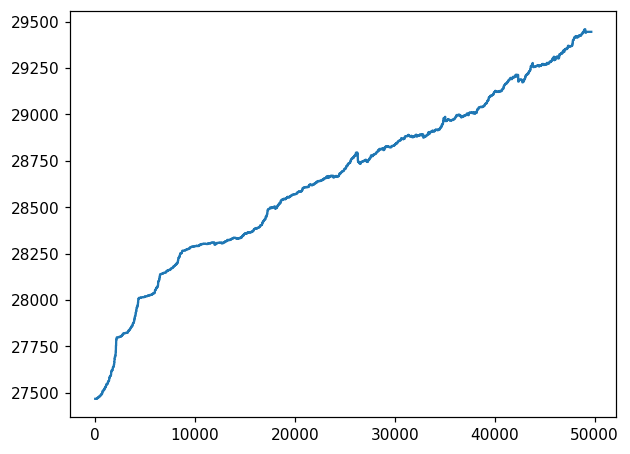

In [804]:
df_main['turbines_in_operation'].plot()

<Axes: >

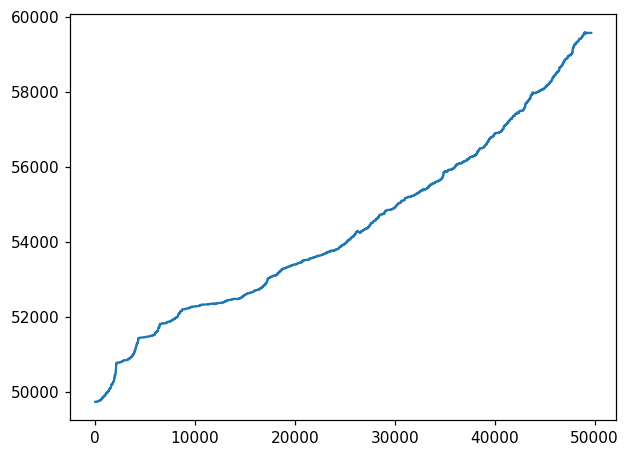

In [806]:
df_main['total_nominal_capacity_operational_turbines_mw'].plot()

In [808]:
df_main.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49656 entries, 0 to 49655
Data columns (total 8 columns):
 #   Column                                          Non-Null Count  Dtype              
---  ------                                          --------------  -----              
 0   datetime_utc                                    49656 non-null  datetime64[ns, UTC]
 1   hour                                            49656 non-null  int32              
 2   day_of_week                                     49656 non-null  int32              
 3   day_of_month                                    49656 non-null  int32              
 4   month_number                                    49656 non-null  int32              
 5   meteorological_season                           49656 non-null  object             
 6   turbines_in_operation                           49656 non-null  int64              
 7   total_nominal_capacity_operational_turbines_mw  49656 non-null  float64            
dt

-----

## Test merging SMARD data onto `df_main` on key datetime
- Dataframes to merge with `df_main`:
    - `df_smard_generated`
    - `df_smard_market_price`
    - `df_smard_installed_capacity`
    - `df_smard_forecasted_generation`

##### Generated data; the response variable `y`

In [809]:
# keep the datetime_cet column for reference
df_main = df_main.merge(df_smard_generated, left_on='datetime_utc', right_on='datetime_cet', how='left')

##### The day-ahead price data

In [810]:
# Figure out how to handle the overlapping cet columns? 
# -> only add suffix to overlapping columns in right df being merged
df_main = df_main.merge(df_smard_market_price, left_on='datetime_utc', right_on='datetime_cet', how='left', suffixes=(None, '_remove'))

##### Installed capacity

In [811]:
# Figure out how to handle the overlapping cet columns? 
# -> only add suffix to overlapping columns in right df being merged
df_main = df_main.merge(df_smard_installed_capacity, left_on='datetime_utc', right_on='datetime_cet', how='left', suffixes=(None, '_remove'))

##### The day-ahead forecasted generation

In [814]:
# Figure out how to handle the overlapping cet columns? 
# -> only add suffix to overlapping columns in right df being merged
df_main = df_main.merge(df_smard_forecasted_generation, left_on='datetime_utc', right_on='datetime_cet', how='left', suffixes=(None, '_remove'))

In [816]:
df_main

,datetime_utc,hour,day_of_week,day_of_month,month_number,meteorological_season,turbines_in_operation,total_nominal_capacity_operational_turbines_mw,datetime_cet,onshore_generated_mwh,datetime_cet_remove,day_ahead_price_eur_mwh,datetime_cet_remove,total_nominal_capacity_smard_mw,datetime_cet_remove,forecasted_generation_smard_mwh
0,2018-01-01 00:00:00+00:00,0,0,1,1,winter,27468,49734.697897,2018-01-01 01:00:00+01:00,29638.00,2018-01-01 01:00:00+01:00,NaN,2018-01-01 01:00:00+01:00,51.633,2018-01-01 01:00:00+01:00,"29.632,75"
1,2018-01-01 01:00:00+00:00,1,0,1,1,winter,27468,49734.697897,2018-01-01 02:00:00+01:00,30173.75,2018-01-01 02:00:00+01:00,NaN,2018-01-01 02:00:00+01:00,51.633,2018-01-01 02:00:00+01:00,"30.978,75"
2,2018-01-01 02:00:00+00:00,2,0,1,1,winter,27468,49734.697897,2018-01-01 03:00:00+01:00,31021.50,2018-01-01 03:00:00+01:00,NaN,2018-01-01 03:00:00+01:00,51.633,2018-01-01 03:00:00+01:00,"32.154,25"
3,2018-01-01 03:00:00+00:00,3,0,1,1,winter,27468,49734.697897,2018-01-01 04:00:00+01:00,31015.00,2018-01-01 04:00:00+01:00,NaN,2018-01-01 04:00:00+01:00,51.633,2018-01-01 04:00:00+01:00,"33.045,5"
4,2018-01-01 04:00:00+00:00,4,0,1,1,winter,27468,49734.697897,2018-01-01 05:00:00+01:00,31534.00,2018-01-01 05:00:00+01:00,NaN,2018-01-01 05:00:00+01:00,51.633,2018-01-01 05:00:00+01:00,"33.644,5"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50395,2023-08-31 19:00:00+00:00,19,3,31,8,summer,29445,59571.404737,2023-08-31 21:00:00+02:00,11080.75,2023-08-31 21:00:00+02:00,125.50,2023-08-31 21:00:00+02:00,57.590,2023-08-31 21:00:00+02:00,9.225
50396,2023-08-31 20:00:00+00:00,20,3,31,8,summer,29445,59571.404737,2023-08-31 22:00:00+02:00,11553.25,2023-08-31 22:00:00+02:00,106.03,2023-08-31 22:00:00+02:00,57.590,2023-08-31 22:00:00+02:00,"9.885,75"
50397,2023-08-31 21:00:00+00:00,21,3,31,8,summer,29445,59571.404737,2023-08-31 23:00:00+02:00,11290.00,2023-08-31 23:00:00+02:00,96.89,2023-08-31 23:00:00+02:00,57.590,2023-08-31 23:00:00+02:00,"10.282,5"
50398,2023-08-31 22:00:00+00:00,22,3,31,8,summer,29445,59571.404737,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN


##### Remove all the duplicate `datetime_cet` columns with suffix `_remove`

In [815]:
df_main['datetime_cet_remove']

,datetime_cet_remove,datetime_cet_remove,datetime_cet_remove
0,2018-01-01 01:00:00+01:00,2018-01-01 01:00:00+01:00,2018-01-01 01:00:00+01:00
1,2018-01-01 02:00:00+01:00,2018-01-01 02:00:00+01:00,2018-01-01 02:00:00+01:00
2,2018-01-01 03:00:00+01:00,2018-01-01 03:00:00+01:00,2018-01-01 03:00:00+01:00
3,2018-01-01 04:00:00+01:00,2018-01-01 04:00:00+01:00,2018-01-01 04:00:00+01:00
4,2018-01-01 05:00:00+01:00,2018-01-01 05:00:00+01:00,2018-01-01 05:00:00+01:00
...,...,...,...
50395,2023-08-31 21:00:00+02:00,2023-08-31 21:00:00+02:00,2023-08-31 21:00:00+02:00
50396,2023-08-31 22:00:00+02:00,2023-08-31 22:00:00+02:00,2023-08-31 22:00:00+02:00
50397,2023-08-31 23:00:00+02:00,2023-08-31 23:00:00+02:00,2023-08-31 23:00:00+02:00
50398,NaT,NaT,NaT


In [667]:
# filter using regex; $ binds the expression to end of a string
df_main.drop(df_main.filter(regex='_remove$').columns, axis=1, inplace=True)

In [668]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 11 columns):
 #   Column                                           Non-Null Count  Dtype              
---  ------                                           --------------  -----              
 0   datetime_utc                                     8760 non-null   datetime64[ns, UTC]
 1   hour                                             8760 non-null   int32              
 2   day_of_week                                      8760 non-null   int32              
 3   day_of_month                                     8760 non-null   int32              
 4   month_number                                     8760 non-null   int32              
 5   meteorological_season                            8760 non-null   object             
 6   turbines_in_operation                            8760 non-null   int64              
 7   total_nominal_capacity_operational_turbines_mwh  8760 non-null   float64      